# Do a Basic MCMC on Noise-less Coeval Boxes

In [1]:
from py21cmmc import mcmc
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from corner import corner

In this notebook we demonstrate how to do the simplest possible MCMC to fit a single astrophysical parameter to a series of coeval brightness temperature boxes without noise, and then visualise the results.

## Running MCMC

First we create the two necessary components, a ``core`` and ``likelihood`` object. Multiple ``core``s and ``likelihood``s are allowed, and they will work together seamlessly. But we need at least one each.

Here we also demonstrate how one can add custom data to the storage, by subclassing the core object. NOTE: there are a lot more options around this, but this is a simple way.

In [2]:
class MyCore(mcmc.CoreCoevalModule):
    def prepare_storage(self, ctx, storage):
        storage['bt'] = ctx.get("brightness_temp")[0].brightness_temp

In [3]:
core = MyCore(
    redshifts = [7, 8, 9],
    user_params = dict(
        HII_DIM = 70,
        BOX_LEN = 150.0
    )
)

likelihood = mcmc.Likelihood1DPowerCoeval(
    datafile = "simple_mcmc_data.txt",
    logk=False
)

Then run the MCMC using these objects, and supplying also a dictionary of parameters that will be varied in the MCMC:

In [4]:
params = {"HII_EFF_FACTOR":[30.0, 20.0, 40.0, 3.0]}

In [5]:
model_name = "SimpleTest"

chain = mcmc.run_mcmc(
    core, likelihood, 
    datadir='.', model_name=model_name,
    params=params, 
    walkersRatio=10, burninIterations=50, sampleIterations=200, threadCount=1, continue_sampling=False
)

Initializing init and perturb boxes for the entire chain... done.
Writing mock data to file


## Analysis

### Accessing chain data

The full chain data, as well as any stored data (as "blobs") is available in the ``storageUtil`` object within the chain.
If access to this "chain" object is lost (eg. the MCMC was run via CLI and is finished), an exact replica of the store object can be read in from file:

In [6]:
store = chain.storageUtil.sample_storage

# Equivalent:
# from py21cmmc.mcmc.storage import HDFStorage
# store = HDFStorage(model_name+".h5", name="sample_0")

This file will always be available, and is saved at ``datadir/model_name.h5``. The ``name=sample_0`` is the default name of the ``group`` within the file where the data is saved. It is possible to use ``sample_1`` etc. by running multiple (indpendent) chains on the same model.

In [7]:
chain = store.get_value("chain")
lnprob = store.get_value("log_prob")
blobs = store.get_value('blobs', flat=True)

niter, nwalkers, nparams = chain.shape

We can see what extra data we saved along the way by viewing the blobs dtype:

In [8]:
blobs.dtype

dtype([('bt', '<f4', (70, 70, 70)), ('power', '<f8', (3, 11)), ('k', '<f8', (11,))])

Then for simplicity we can extract these:

In [9]:
k = blobs['k']
model_power = blobs['power']

print(k.shape, model_power.shape)

_, nz, nk = model_power.shape

(2000, 11) (2000, 3, 11)


Here we notice that ``k`` should be the same on each iteration, so we take just the first:

In [10]:
print(np.all(k[0] == k[1]))
k = k[0]

True


Finally, we also want to access the *data* to which the models have been compared. Since we have access to the original ``likelihood`` object, we can easily pull this from it. However, we equivalently could have read it in from file (this file is *not* always present, only if ``datafile`` is present in the likelihood constructor):

In [11]:
p_data = np.array(likelihood.p_data)
k_data = likelihood.k_data

# Equivalent
# data = np.genfromtxt("simple_mcmc_data.txt")
# k_data = data[:,0]
# p_data = data[:,1:]

We check that the data and model *k* are the same:

In [12]:
print(np.all(k_data == k))
print(p_data.shape == model_power[0].shape)

True
True


### Model Plot

Text(0,0.5,'$k^3 P$')

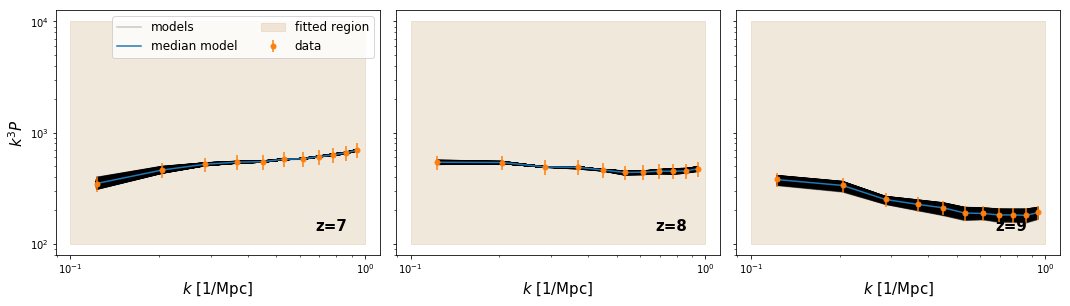

In [13]:
fig, ax = plt.subplots(1, nz, sharex=True, sharey=True, figsize=(6*nz, 4.5), 
                      subplot_kw={"xscale":'log', "yscale":'log'}, gridspec_kw={"hspace":0.05, 'wspace':0.05})

for i in range(nz):
    this_power = model_power[:,i,:]
    this_data = p_data[i]

    
    ax[i].fill_between([0.1, 1.0], 1e2, 1e4, color='tan', alpha=0.3, label="fitted region")

    label="models"
    every=1
    
    for pp in this_power[::every]:
        ax[i].plot(k, pp*k**3, color='k', alpha=0.2, label=label, zorder=1)
        if label:
            label=None

    mean = np.mean(this_power*k**3, axis=0)
    std = np.std(this_power*k**3, axis=0)
    md = np.median(this_power*k**3, axis=0)

    ax[i].fill_between(k, mean - std, mean+std, color="C0", alpha=0.6)
    ax[i].plot(k, md, color="C0", label="median model")

    ax[i].errorbar(k, this_data*k**3, yerr = (0.15*this_data*k**3), color="C1", 
                 label="data", ls="None", markersize=5, marker='o')
                 
    ax[i].set_xlabel("$k$ [1/Mpc]", fontsize=15)
    ax[i].text(0.8, 0.1, "z=%s"%core.redshifts[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold')
    
ax[0].legend(ncol=2, fontsize=12)
#plt.ylim((3.1e2, 3.5e3))


ax[0].set_ylabel("$k^3 P$", fontsize=15)

#plt.savefig(join(direc, modelname+"_power_spectrum_plot.pdf"))

### Corner Plot

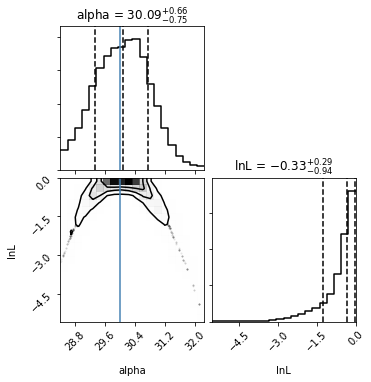

In [14]:
INCLUDE_LNL = True
truths = [30.0]

if INCLUDE_LNL:
    plotchain = np.vstack((chain.T,np.atleast_3d(lnprob).T)).T.reshape((-1, nparams+1))
    truths += [None]
    labels = ["alpha", 'lnL']
else:
    plotchain = chain.reshape((-1, nparams))
    labels = ['alpha']
    
corner(
    plotchain, 
    labels=labels, 
    truths=truths,
    smooth=0.75,
    smooth1d=1.0,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84]
);


### Trace Plot

NameError: name 'params' is not defined

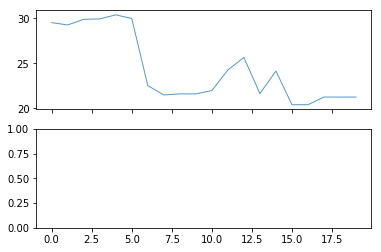

In [78]:
fig, ax = plt.subplots(nparams+1,1, sharex=True)
for i in range(nwalkers):
    for j in range(nparams):
        ax[j].plot(chain[:,i,j], color='C%s'%(i%8), alpha=0.75, lw=1)
        ax[j].set_ylabel(params[j])

    ax[nparams].plot(lnprob[:, i], color='C%s'%(i%8), alpha=0.75, lw=1)
    ax[nparams].set_ylabel("lnL")
#    ax[nparams].set_ylim(-5,0)